In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import RandomSampleImputer
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, make_scorer, recall_score,
                             roc_curve, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2024-05-26 19:44:02.111687: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:44:02.225470: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 19:44:02.349410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 19:44:04.300999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Classification

## Objectives
- Fit and evaluate a classification model to predict whether a patient will be affected by heart disease or not.

## Inputs
- Path to the heart dataset: `outputs/datasets/collection/heart.csv`

## Outputs
- Training set (features and target)
- Test set (features and target)
- Data cleaning and Feature Engineering pipeline
- Modeling pipeline
- Confusion matrix

---




## Setting working Directory

The following steps allow setting "heart_attack_risk" as the new working directory:

- Retrieve the current directory and print it.


In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/Heart_attack_risk/jupyer_notebooks'

- Set the new working directory as the parent of the previous current directory
- As a result, "heart_attack_risk" becomes the new working directory

In [3]:
os.chdir(os.path.dirname(current_dir))


---

## Load data

In [4]:
df = (pd.read_csv("outputs/datasets/collection/heart.csv"))
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


## Data cleaning and Feature Engineering

In [5]:
def PipelineDataCleaningAndFeatureEngineering():
    """
    Creates a scikit-learn Pipeline for data
    cleaning and feature engineering.
    """
    pipeline_base = Pipeline([
        ('RandomSampleImputer',
         RandomSampleImputer(random_state=42,
                             variables=['Cholesterol'])),
        ('OrdinalCategoricalEncoder',
         OrdinalEncoder(encoding_method='arbitrary',
                        variables=['Sex', 'ChestPainType', 'RestingECG',
                                   'ExerciseAngina', 'ST_Slope'])),
        ('winsorizer_iqr',
         Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                    variables=['Age', 'RestingBP', 'Cholesterol', 'Oldpeak']))
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('RandomSampleImputer',
                 RandomSampleImputer(random_state=42,
                                     variables=['Cholesterol'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Sex', 'ChestPainType', 'RestingECG',
                                           'ExerciseAngina', 'ST_Slope'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'RestingBP', 'Cholesterol',
                                       'Oldpeak']))])

## Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
def PipelineClf(model):
    """
    Creates a scikit-learn Pipeline for feature selection.
    """
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation



In [7]:
class HyperparameterOptimizationSearch:
    """
    A class for performing hyperparameter optimization
    using grid search across multiple models.
    """

    def __init__(self, models, params):
        """
        Initializes the HyperparameterOptimizationSearch object.
        """
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        """
        Fits the grid search on the provided data.
        """
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        """
        Generates a summary of grid search scores.
        """
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In the Cholesterol feature, I substitute 0 with NaN to enable data cleaning in the pipeline.

In [8]:
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)

## Split Train and Test Set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['HeartDisease'], axis=1),
    df['HeartDisease'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


## Handle Target Imbalance


In [10]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


Check Train Set Target distribution



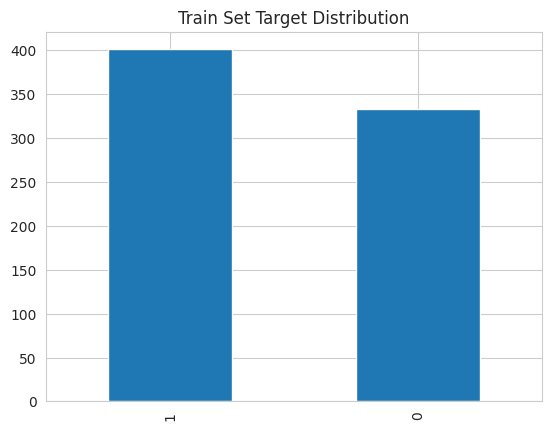

In [11]:
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

No imbalance observed in target feature

## Grid Search CV - Sklearn
### Utilize standard hyperparameters to find the most suitable algorithm

Note: XGBoost was initially included in the list of classifiers. However, it was not selected as one of the best, and due to its large library size, deployment on the cloud was not feasible. Therefore, I removed XGBoost from the list of classifiers.

In [12]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Performing hyperparameter optimization with a focus on the recall score

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search,
                                          params=params_quick_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

Check results



In [14]:
grid_search_summary, grid_search_pipelines = \
    search.score_summary(sort_by='mean_score')

grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.825,0.862685,0.925926,0.035683
3,GradientBoostingClassifier,0.825,0.855278,0.888889,0.026093
2,RandomForestClassifier,0.777778,0.843056,0.9,0.042145
4,ExtraTreesClassifier,0.775,0.800463,0.85,0.028722
5,AdaBoostClassifier,0.7125,0.758056,0.8375,0.045367
1,DecisionTreeClassifier,0.703704,0.743241,0.7625,0.02453


### Performing an extensive search on the most suitable algorithm to find the best hyperparameter configuration

Define the model and parameters for an extensive search

In [16]:
models_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
}
params_search = {
    "LogisticRegression": {
         'model__C': [0.1, 1, 10],
         'model__penalty': ['l2'],
         'model__solver': ['liblinear', 'lbfgs', 'saga'],
         'model__class_weight': [None, 'balanced']
    }
}

Set up the hyperparameter optimization process for logistic regression

In [17]:
search = HyperparameterOptimizationSearch(models=models_search,
                                          params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results



In [18]:
grid_search_summary, grid_search_pipelines = \
    search.score_summary(sort_by='mean_score')

grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__C,model__class_weight,model__penalty,model__solver
2,LogisticRegression,0.825,0.865216,0.91358,0.029295,0.1,None,l2,saga
1,LogisticRegression,0.825,0.865216,0.91358,0.029295,0.1,None,l2,lbfgs
12,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,liblinear
7,LogisticRegression,0.825,0.862685,0.925926,0.035683,1,None,l2,lbfgs
8,LogisticRegression,0.825,0.862685,0.925926,0.035683,1,None,l2,saga
14,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,saga
13,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,lbfgs
0,LogisticRegression,0.825,0.860247,0.901235,0.025884,0.1,None,l2,liblinear
6,LogisticRegression,0.825,0.860216,0.91358,0.031391,1,None,l2,liblinear
5,LogisticRegression,0.8125,0.845278,0.888889,0.027366,0.1,balanced,l2,saga


Get the best model name programmatically

In [19]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'LogisticRegression'

Parameters for best model

In [20]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__C': 0.1,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}


Define the best classifier pipeline.

In [21]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=0))),
                ('model', LogisticRegression(C=0.1, random_state=0))])

## Assess feature importance

In [22]:
X_train.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
378,70.0,0,0,140,177.0,1,0,157,0,2.0,0
356,46.0,0,0,115,274.0,0,0,113,0,1.5,0
738,65.0,1,1,160,360.0,0,1,151,1,0.8,1


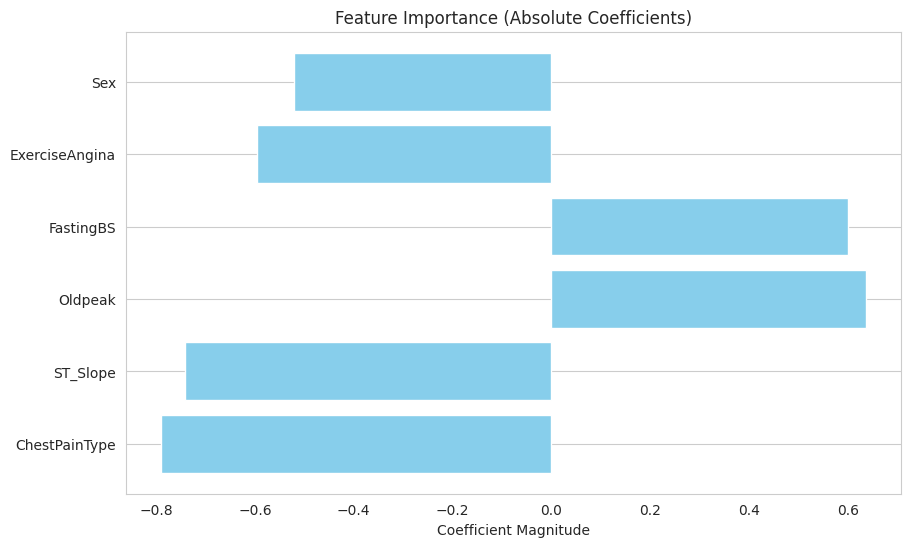

In [23]:
coefficients = pipeline_clf['model'].coef_[0]
best_features = X_train.columns[
                                pipeline_clf['feat_selection']
                                .get_support()
                                ]
df_coefficients = pd.DataFrame({'Feature': best_features,
                                'Coefficient': coefficients})
df_coefficients_sorted = (df_coefficients
                          .reindex(df_coefficients['Coefficient']
                                   .abs()
                                   .sort_values(ascending=False)
                                   .index))

plt.figure(figsize=(10, 6))
plt.barh(df_coefficients_sorted['Feature'],
         df_coefficients_sorted['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance (Absolute Coefficients)')
plt.grid(axis='x')
plt.show()


### Evaluate Pipeline on Train and Test Sets

In [24]:
def confusion_matrix_and_report(X, y, pipeline, label_map):
    """
    Generate and print the confusion matrix and classification report.
    """

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    """
    Evaluate the performance of a classifier on both train and test sets.
    """
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Assessing Pipeline performances

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map=['High risk', ' Low risk']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual High risk Actual  Low risk
Prediction High risk              274               53
Prediction  Low risk               59              348


---  Classification Report  ---
              precision    recall  f1-score   support

   High risk       0.84      0.82      0.83       333
    Low risk       0.86      0.87      0.86       401

    accuracy                           0.85       734
   macro avg       0.85      0.85      0.85       734
weighted avg       0.85      0.85      0.85       734
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual High risk Actual  Low risk
Prediction High risk               58               13
Prediction  Low risk               19               94


---  Classification Report  ---
              precision    recall  f1-score   support

   High risk       0.82      0.75      0.78        77
    Low risk       0.83      0.88      0.85       107

    accuracy 

- Precision and Recall for the Train set are both greater than 80%.
- For the Test set, Precision is also greater than 80%
- Overall, the pipeline already meets the business requirements of having a precision greater than 80%.

## Evaluate on Train and Test Sets


In [26]:
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    """
    Evaluate the regression model performance on
    both the training and test sets.
    """
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    """
    Evaluate the performance of a regression model.
    """
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def plot_roc_curve_classifier(classifier, X_test, y_test, best_features):
    """
    Plot the ROC curve for a binary classifier.
    """
    X_test_selected = X_test[best_features]
    fpr, tpr, thresholds = roc_curve(y_test,
                                     classifier
                                     .predict_proba(X_test_selected)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


Evaluate Performance



Number of features in X_train: 11
Number of features in X_test: 11
Model Evaluation 

* Train Set
R2 Score: 0.384
Mean Absolute Error: 0.153
Mean Squared Error: 0.153
Root Mean Squared Error: 0.391


* Test Set
R2 Score: 0.285
Mean Absolute Error: 0.174
Mean Squared Error: 0.174
Root Mean Squared Error: 0.417




/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


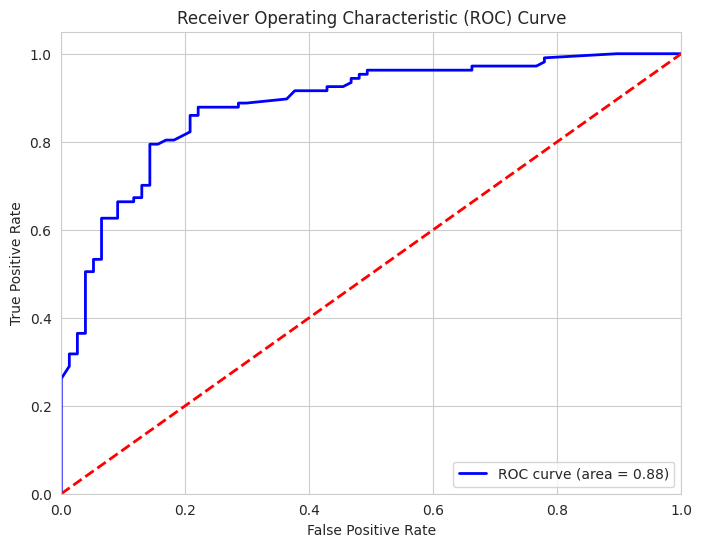

In [27]:
print("Number of features in X_train:", X_train.shape[1])
print("Number of features in X_test:", X_test.shape[1])

classifier_instance = pipeline_clf.named_steps['model']
regression_performance(X_train, y_train, X_test, y_test, pipeline_clf)
plot_roc_curve_classifier(classifier_instance, X_test, y_test, best_features)

The ROC curve compares the model's results to those of a random sampler, and plots the sensitivity against 1-specifity.
The AUC of 0.88 proves the excellent ability of the model to distinguish between low-risk and high-risk patients

Save version

In [28]:
version = 'v1'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_heart_disease/v1'


Save train set

In [29]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [30]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Save test set

In [31]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [32]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Save pipelines

In [33]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('RandomSampleImputer',
                 RandomSampleImputer(random_state=42,
                                     variables=['Cholesterol'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Sex', 'ChestPainType', 'RestingECG',
                                           'ExerciseAngina', 'ST_Slope'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'RestingBP', 'Cholesterol',
                                       'Oldpeak']))])

In [34]:
joblib.dump(value=pipeline_data_cleaning_feat_eng,
            filename=f"{file_path}/pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_heart_disease/v1/pipeline_data_cleaning_feat_eng.pkl']

In [35]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=0))),
                ('model', LogisticRegression(C=0.1, random_state=0))])

In [36]:
joblib.dump(value=pipeline_clf,
            filename=f"{file_path}/clf_pipeline.pkl")

['outputs/ml_pipeline/predict_heart_disease/v1/clf_pipeline.pkl']

## Testing a Neural network approach

To ensure that prior data manipulation has not compromised the integrity of the dataset, I will recommence by partitioning the `heart` dataset into training and testing subsets.

Before spltting the dataset I replace 0 with nan in the cholesterole feature

In [53]:
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['HeartDisease'], axis=1),
                                    df['HeartDisease'],
                                    test_size=0.2,
                                    random_state=0
                                    )

Create the validation set

In [55]:
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train,
                                    y_train,
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape)
print("* Validation set:",  X_val.shape, y_val.shape)
print("* Test set:",   X_test.shape, y_test.shape)

* Train set: (587, 11) (587,)
* Validation set: (147, 11) (147,)
* Test set: (184, 11) (184,)


The feature engineering pipeline will include the following:
- `RandomSampleImputer` for cholesterol
- `OneHotEncoder` for categorical variable

Defining the the OneHotEncoder

In [56]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG',
                       'ExerciseAngina', 'ST_Slope']
categorical_transformer = OneHotEncoder(drop='first',
                                        sparse_output=False)
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough'
)

Building the pipeline for data cleaning and feature engineering

In [57]:
def PipelineDataCleaningAndFeatureEngineering():
    """
    Creates a scikit-learn Pipeline for data
    cleaning and feature engineering.
    """
    pipeline_base = Pipeline([
        ('RandomSampleImputer',
         RandomSampleImputer(random_state=42,
                             variables=['Cholesterol'])),
        ('preprocessor', preprocessor)
    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('RandomSampleImputer',
                 RandomSampleImputer(random_state=42,
                                     variables=['Cholesterol'])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])]))])

Running pipeline on all sets

In [58]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_validation = pipeline_data_cleaning_feat_eng.fit_transform(X_val)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape,
      X_test.shape, y_test.shape)

(587, 15) (587,) (147, 11) (147,) (184, 15) (184,)


The preprocessing pipeline will exclusively incorporate feature scaling as a preprocessing step.

In [59]:
def pipeline_pre_processing():
    """
    Create the scikit-learn Pipeline for preprocessing
    """

    pipeline_base = Pipeline([("feat_scaling", StandardScaler())])
    return pipeline_base


Execute the pipeline on all datasets.

In [60]:
pipeline = pipeline_pre_processing()
X_train = pipeline.fit_transform(X_train)
X_validation = pipeline.transform(X_validation)
X_test = pipeline.transform(X_test)


Building the neural network model

In [61]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def create_tf_model_sigmoid(n_features):
    """
    Create a TensorFlow model with a sigmoid activation function
    """

    model = Sequential()
    model.add(Dense(units=n_features, activation='relu',
                    input_shape=(n_features, )))
    model.add(Dropout(0.25))

    model.add(Dense(units=20, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=10, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=5, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['precision'])

    return model

Visualize network structure

In [62]:
model = create_tf_model_sigmoid(n_features=X_train.shape[1])
model.summary()

/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 831 (3.25 KB)

 Trainable params: 831 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

Fitting the model

In [78]:
early_stop = EarlyStopping(monitor='val_precision', mode='max',
                           verbose=1, patience=20)

In [79]:
model = create_tf_model_sigmoid(n_features=X_train.shape[1])
model.fit(x=X_train,
          y=y_train,
          epochs=75,
          validation_data=(X_validation, y_val),
          verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/75


/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7263 - precision: 0.5328 - val_loss: 0.6563 - val_precision: 0.6325
Epoch 2/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6779 - precision: 0.5767 - val_loss: 0.6230 - val_precision: 0.7308
Epoch 3/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6632 - precision: 0.5942 - val_loss: 0.5826 - val_precision: 0.7959
Epoch 4/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6311 - precision: 0.6145 - val_loss: 0.5382 - val_precision: 0.8571
Epoch 5/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6163 - precision: 0.6480 - val_loss: 0.4954 - val_precision: 0.8652
Epoch 6/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5862 - precision: 0.6867 - val_loss: 0.4578 - val_precision: 0.9024
Epoch 7/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5718 - precision: 0.6723 - val_loss: 0.4345 - val_precision: 0.9136
Epoch 8/75
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5046 - precision: 0.7141 - val_loss: 0.4065 - val_prec

Evaluating the model

In [80]:
history = pd.DataFrame(model.history.history)
history.head()

,loss,precision,val_loss,val_precision
0,0.725583,0.537118,0.656305,0.632479
1,0.678929,0.575829,0.623020,0.730769
2,0.652752,0.595533,0.582610,0.795918
3,0.635453,0.632124,0.538245,0.857143
4,0.610874,0.650131,0.495426,0.865169


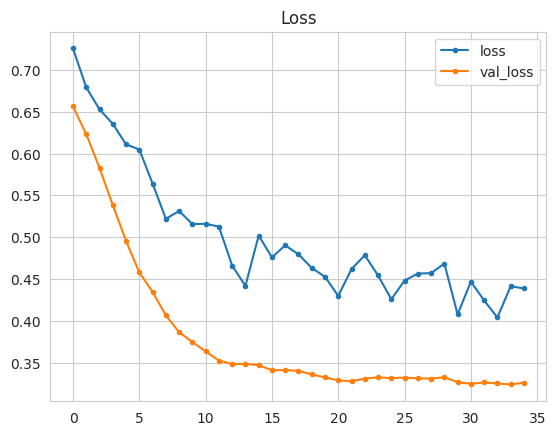

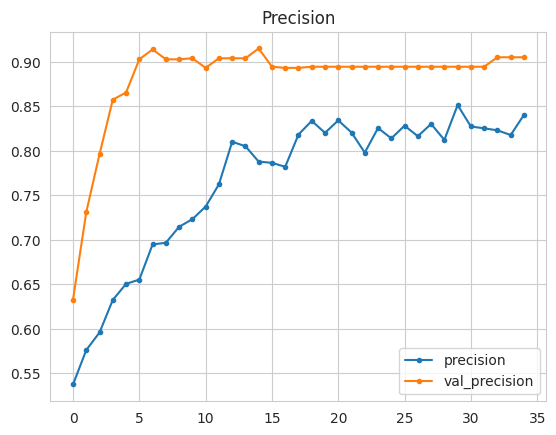

In [81]:
sns.set_style("whitegrid")
history[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.show()

print("\n")
history[['precision', 'val_precision']].plot(style='.-')
plt.title("Precision")
plt.show()

The loss plot for training and validation data follow a similar path and are close to each other. It looks like the network learned the patterns.

In the accuracy plot that both train and validation accuracies keep increasing until a plateau.

Create confusion matrix for neural network approach

In [73]:
def confusion_matrix_and_report_neural_network(X, y, pipeline, label_map):
    """
    Generate and print confusion matrix and classification report
    """
    prediction = pipeline.predict(X).reshape(-1)
    prediction = np.where(prediction < 0.5, 0, 1)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test,
                    X_val, y_val, pipeline, label_map):
    """
    Evaluate classifier performance on train, validation, and test sets
    """

    print("#### Train Set #### \n")
    confusion_matrix_and_report_neural_network(X_train, y_train,
                                               pipeline, label_map)

    print("#### Validation Set #### \n")
    confusion_matrix_and_report_neural_network(X_val, y_val,
                                               pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report_neural_network(X_test, y_test,
                                               pipeline, label_map)

In [82]:
clf_performance(X_train, y_train,
                X_test, y_test,
                X_validation, y_val,
                model,
                label_map=['High risk', ' Low risk']
                )

#### Train Set #### 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
---  Confusion Matrix  ---
                     Actual High risk Actual  Low risk
Prediction High risk              233               27
Prediction  Low risk               39              288


---  Classification Report  ---
              precision    recall  f1-score   support

   High risk       0.90      0.86      0.88       272
    Low risk       0.88      0.91      0.90       315

    accuracy                           0.89       587
   macro avg       0.89      0.89      0.89       587
weighted avg       0.89      0.89      0.89       587
 

#### Validation Set #### 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
---  Confusion Matrix  ---
                     Actual High risk Actual  Low risk
Prediction High risk               53               10
Prediction  Low risk                8               76


---  Classification Report  ---
              precision    recall  f1-score   support

   High risk       0.84      0.87     

Both the traditional ML pipeline and the neural network demonstrate similar results. However, since the traditional ML pipeline was implemented first and Streamlit already utilizes the traditional ML approach, only the traditional ML pipeline will be saved.

Furthermore, the library size is incompatible with Heroku.